In [1]:
import time
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
# get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import statsmodels.api as sm
from sklearn import preprocessing 
import ema_workbench.em_framework.evaluators
import matplotlib.pyplot as plt

In [2]:
import os
from dest_directories import gz_path, fig_path
from dicemodel.noDICE_v7 import PyDICE
model_version = 'v7'

from dicemodel.specs import nordhaus_policy, reference_scenario, change_fontsize

In [3]:
from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, TimeSeriesOutcome, ScalarOutcome, ArrayOutcome, Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
from ema_workbench import save_results, load_results
from ema_workbench.analysis import prim, cart
from ema_workbench.analysis import scenario_discovery_util as sdutil
from ema_workbench.analysis import plotting, plotting_util, pairs_plotting, parcoords

ema_logging.log_to_stderr(ema_logging.INFO)

model = PyDICE()
dice_sm = Model('dicesmEMA', function=model)

In [4]:
dice_opt = pd.read_excel("DICE2013R.xlsm" ,sheet_name = "Opttax", index_col = 0)


## Directed search: Worst Case Scenario

In [5]:
dice_sm.uncertainties = [
                            # IntegerParameter('t2xco2_index', 0, 999),
                            #  IntegerParameter('t2xco2_dist',0,2),
                            #  IntegerParameter('fdamage', 0, 2),
                             RealParameter('tfp_gr',  0.07, 0.09),
                             RealParameter('sigma_gr', -0.012, -0.008),
                             RealParameter('pop_gr', 0.1, 0.15),
                             RealParameter('fosslim',  4000.0, 13649),
                             IntegerParameter('cback', 100, 600),
                             RealParameter('emdd', -1, 0.99),
                            #  IntegerParameter('vd_switch', 0, 1),
                            ]
dice_sm.constants = [Constant('vd_switch', 1) ]

dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                      RealParameter('prtp_con',  0.001, 0.015),
                      RealParameter('emuc', 1.01, 2.00),
                      IntegerParameter('periodfullpart', 10, 58),
                      IntegerParameter('miu_period', 10, 58)
                      ]

                        
dice_sm.outcomes = [
            # ScalarOutcome('Atmospheric Temperature 2300', kind=ScalarOutcome.MINIMIZE),
            ScalarOutcome('Mean Atmospheric Temperature', kind=ScalarOutcome.MINIMIZE),
            
            ScalarOutcome('Welfare Discounted Utility Component 2300', kind=ScalarOutcome.MAXIMIZE),
            ScalarOutcome('Welfare Discounted Disutility Component 2300', kind=ScalarOutcome.MINIMIZE),

            ScalarOutcome('Total Output 2300', kind=ScalarOutcome.INFO),
            ScalarOutcome('Per Capita Consumption 2300', kind=ScalarOutcome.INFO),
            ScalarOutcome('Consumption Growth 2300', kind=ScalarOutcome.INFO),
            ScalarOutcome('Utility of Consumption 2300', kind=ScalarOutcome.INFO),
            ScalarOutcome('Per Capita Damage 2300', kind=ScalarOutcome.INFO),
            ScalarOutcome('Damage Growth 2300', kind=ScalarOutcome.INFO),
            ScalarOutcome('Disutility of Damage 2300', kind=ScalarOutcome.INFO),
            ScalarOutcome('Welfare 2300', kind=ScalarOutcome.INFO),

            # ScalarOutcome('Undiscounted Period Welfare 2300', kind=ScalarOutcome.INFO),
            # ScalarOutcome('Consumption SDR 2300', kind=ScalarOutcome.INFO),
            # ScalarOutcome('Damage SDR 2300', kind=ScalarOutcome.INFO),
            ScalarOutcome('Mean SCC 2300', kind=ScalarOutcome.INFO)
            ]


In [6]:
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import EpsilonProgress

BaseEvaluator.reporting_frequency = 0.1

In [7]:
nord_optimal_policy = Policy('nord_optimal_policy', **nordhaus_policy(np.mean(dice_opt.iloc[129]),prtp_con =0.015,emuc=1.45, miu_period= 0, periodfullpart=29 ))  # vd_switch=1
nord_optimal_policy

Policy({'sr': 0.24868248835166676, 'prtp con': 0.015, 'emuc': 1.45, 'periodfullpart': 29, 'miu_period': 0})

In [8]:
eps = [0.0001] * (int(len(dice_sm.outcomes)))
convergence_metrics = [EpsilonProgress()]

In [14]:

nfe = 100000

run = '47_Nord_WCS_' 
#  run 15 with V(D) minimize,min and max limits to V(D) are both zer0. Probably only keeps V(D) switch off outcomes 
#  run 16: V(D) and U(C) set to info. has SDRs, U(C), V(D) min & max NaN, Temp min & max both 0
# run 17: same as run 16, but without the SDRs. Still trying to figure this out. Ah okay, convergence savefile was overwriting results. Let's see what happens now. only one result row
# run 17b: changed eps to 0.0001, turned convergence off
# run 18: eps 0.01
# run 19: turned convergence back on. forgot to add convergence var in evaluator
# run 20: addad conv in eval
# run 21: removing all .info, converting into max or min. Looks good, but only 5 outcomes
# run 22: eps = 0.001
# run 23: eps = 0.0001, vd_switch always 1 (putting it into levers)
# run 24: model v7 (t2xco2 removed)
# run 35: model v7.2 ------wrong emdd range
# run 36: corrected emdd range
# run 37: WCS, eps = 0.0001
# RUN 38-41: Other places
# run 41: WCS, with disaggregated welfare components 
# run 45: WCS, vd = 0
# run 46: WCS, vd = 0,1
# run 47: WCS, vd = 1


In [15]:

for outcome in dice_sm.outcomes:
    if not outcome.kind == ScalarOutcome.INFO:
            if outcome.kind == ScalarOutcome.MINIMIZE:
                outcome.kind = ScalarOutcome.MAXIMIZE
            else:
                outcome.kind = ScalarOutcome.MINIMIZE
    print(outcome, outcome.kind)
#  How do I get the .INFO outcomes to show in the WCS 

ScalarOutcome('Mean Atmospheric Temperature') 1
ScalarOutcome('Welfare Discounted Utility Component 2300') -1
ScalarOutcome('Welfare Discounted Disutility Component 2300') 1
ScalarOutcome('Total Output 2300') 0
ScalarOutcome('Per Capita Consumption 2300') 0
ScalarOutcome('Consumption Growth 2300') 0
ScalarOutcome('Utility of Consumption 2300') 0
ScalarOutcome('Per Capita Damage 2300') 0
ScalarOutcome('Damage Growth 2300') 0
ScalarOutcome('Disutility of Damage 2300') 0
ScalarOutcome('Welfare 2300') 0
ScalarOutcome('Mean SCC 2300') 0


In [16]:
start = time.time()
print("starting search for wcs", flush=True)
with MultiprocessingEvaluator(dice_sm, n_processes=16) as evaluator:
    results, convergence = evaluator.optimize(
        nfe=nfe,
        searchover='uncertainties',
        reference=nord_optimal_policy,
        epsilons=eps,
        convergence=convergence_metrics
        )
                                                

results.to_csv(os.path.join(gz_path, str(run) +'_v7.4_results_VD_ON' +  '.csv'))
convergence.to_csv(os.path.join(gz_path, str(run) + '_v7.4_convergence_VD_ON' +  '.csv'))

end = time.time()
print('Directed Search of WCS time is ' + str(round((end - start) / 60)) + ' mintues')

starting search for wcs
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/100000 nfe


In [49]:
# results = pd.read_csv(os.path.join(gz_path, 'run_41_Nord_WCS__v7.4_results.csv'))
# results = results.drop(results.columns[0], axis = 1)


In [50]:
# convergence = pd.read_csv(os.path.join(gz_path, 'run_41_Nord_WCS__v7.4_convergence.csv'))

In [69]:
# V(D) switch OFF
results

,tfp_gr,sigma_gr,pop_gr,fosslim,cback,emdd,Mean Atmospheric Temperature,Welfare 2300
0,0.079665,-0.012,0.100004,4620.525587,122,0.030569,0.332414,-3854.760075
1,0.073482,-0.012,0.100000,5490.258949,283,0.006226,0.334771,-3854.729499
2,0.070003,-0.012,0.100000,5505.779091,116,-0.160246,0.332328,-3854.761009
3,0.072339,-0.012,0.100000,4669.679907,600,0.004118,0.339661,-3854.721135
4,0.070752,-0.012,0.100000,4294.853782,108,0.830830,0.332212,-3854.762235
5,0.072501,-0.012,0.100000,4760.547116,171,0.049575,0.333129,-3854.751946
6,0.070019,-0.012,0.100000,4577.490766,101,-0.019502,0.332111,-3854.763290
7,0.072577,-0.012,0.100000,6055.127821,305,-0.484529,0.335096,-3854.724352
8,0.070029,-0.012,0.100000,4589.476348,217,-0.472618,0.333802,-3854.743431
9,0.075742,-0.012,0.100000,6551.227438,306,-0.669931,0.335110,-3854.724112


In [6]:
# V(D) switch ON
results

NameError: name 'results' is not defined

In [12]:
results

,tfp_gr,sigma_gr,pop_gr,fosslim,cback,emdd,vd_switch,Mean Atmospheric Temperature,Welfare Discounted Utility Component 2300,Welfare Discounted Disutility Component 2300
0,0.074463,-0.011998,0.100011,7823.340104,588,0.586433,1,0.339428,-3855.106893,-3855.106887


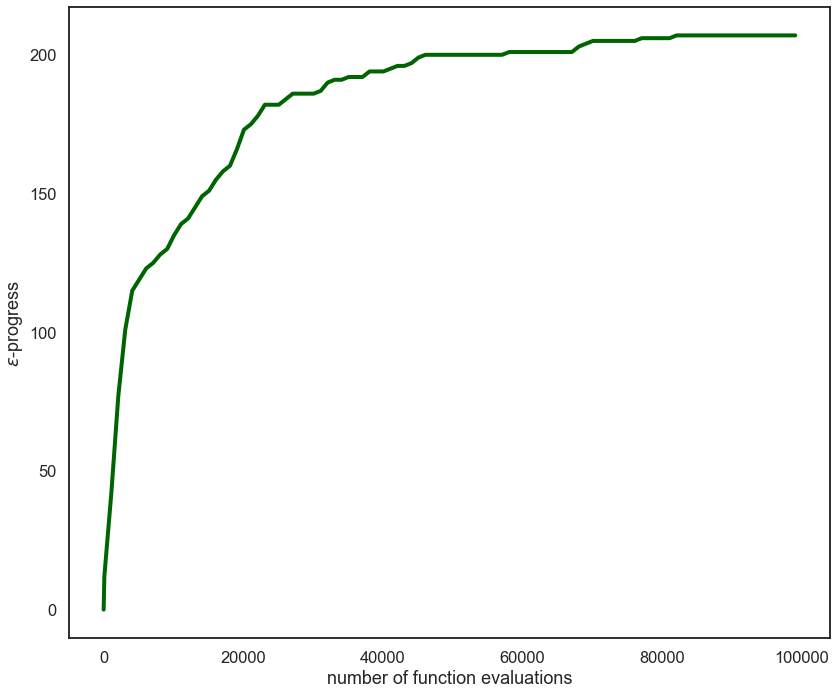

In [70]:
# V(D) switch OFF
sns.set_context("talk")
plt.figure(figsize=(12,10))
plt.plot(convergence.nfe, convergence.epsilon_progress, color = "darkgreen", linewidth=4)
plt.ylabel('$\epsilon$-progress')
plt.xlabel('number of function evaluations')
plt.tight_layout()
plt.savefig(os.path.join(fig_path, str(run) + 'DSearch_convergence_VD_0' + '.png'))

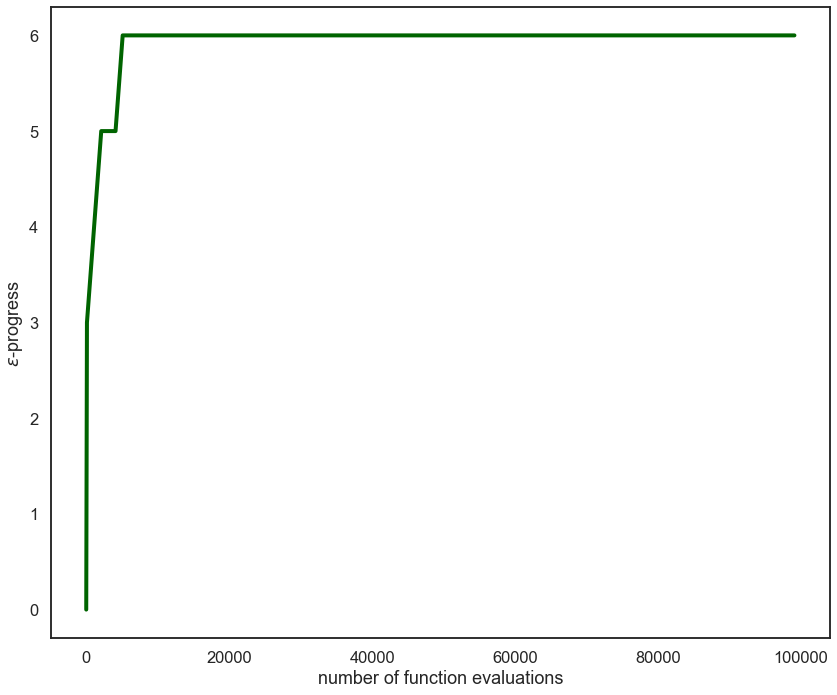

In [53]:
# V(D) switch ON
sns.set_context("talk")
plt.figure(figsize=(12,10))
plt.plot(convergence.nfe, convergence.epsilon_progress, color = "darkgreen", linewidth=4)
plt.ylabel('$\epsilon$-progress')
plt.xlabel('number of function evaluations')
plt.tight_layout()
plt.savefig(os.path.join(fig_path, str(run) + 'DSearch_convergence_VD_1' + '.png'),bbox_inches='tight')

In [71]:
# V(D) switch OFF
data = results.loc[:, [o.name for o in dice_sm.uncertainties]]
limits = parcoords.get_limits(data)
limits

,tfp_gr,sigma_gr,pop_gr,fosslim,cback,emdd
0,0.070003,-0.012,0.100000,4017.686241,101,-0.971511
1,0.082703,-0.012,0.100026,6551.227438,600,0.866778


In [54]:
# V(D) switch ON
data = results.loc[:, [o.name for o in dice_sm.uncertainties]]
limits = parcoords.get_limits(data)
limits

,tfp_gr,sigma_gr,pop_gr,fosslim,cback,emdd
0,0.081964,-0.011966,0.100286,5896.807381,600,0.836634
1,0.081964,-0.011966,0.100286,5896.807381,600,0.836634


In [73]:
# # V(D) switch OFF
# data_outcomes = results.loc[:, [o.name for o in dice_sm.outcomes]]
# print(data_outcomes.idxmax())
# print(data_outcomes.idxmin())

In [74]:
# # V(D) switch ON
# data_outcomes = results.loc[:, [o.name for o in dice_sm.outcomes]]
# print(data_outcomes.idxmax())
# print(data_outcomes.idxmin())

In [ ]:
# parresults = results.iloc[:,[1,2,4,5,7]]
# parresults

In [75]:
# V(D) switch OFF
limits['tfp_gr'] = limits['tfp_gr'].round(decimals=4)
# limits['sigma_gr'] = limits['sigma_gr'].round(decimals=4)
# limits['pop_gr'] = limits['pop_gr'].round(decimals=4)
limits['fosslim'] = limits['fosslim'].round(decimals=1)

In [29]:
# V(D) switch ON
limits['tfp_gr'] = limits['tfp_gr'].round(decimals=2)
limits['sigma_gr'] = limits['sigma_gr'].round(decimals=4)
limits['pop_gr'] = limits['pop_gr'].round(decimals=4)
limits['fosslim'] = limits['fosslim'].round(decimals=1)


In [76]:
# V(D) switch OFF
# limits=limits.round(decimals=2)
limits

,tfp_gr,sigma_gr,pop_gr,fosslim,cback,emdd
0,0.0700,-0.012,0.100000,4017.7,101,-0.971511
1,0.0827,-0.012,0.100026,6551.2,600,0.866778


In [17]:
# V(D) switch ON
limits=limits.round(decimals=2)
limits

,tfp_gr,sigma_gr,pop_gr,fosslim,cback,emdd,vd_switch
0,0.07,-0.01,0.1,4531.08,100,-1.00,0
1,0.09,-0.01,0.1,13622.05,600,0.99,1


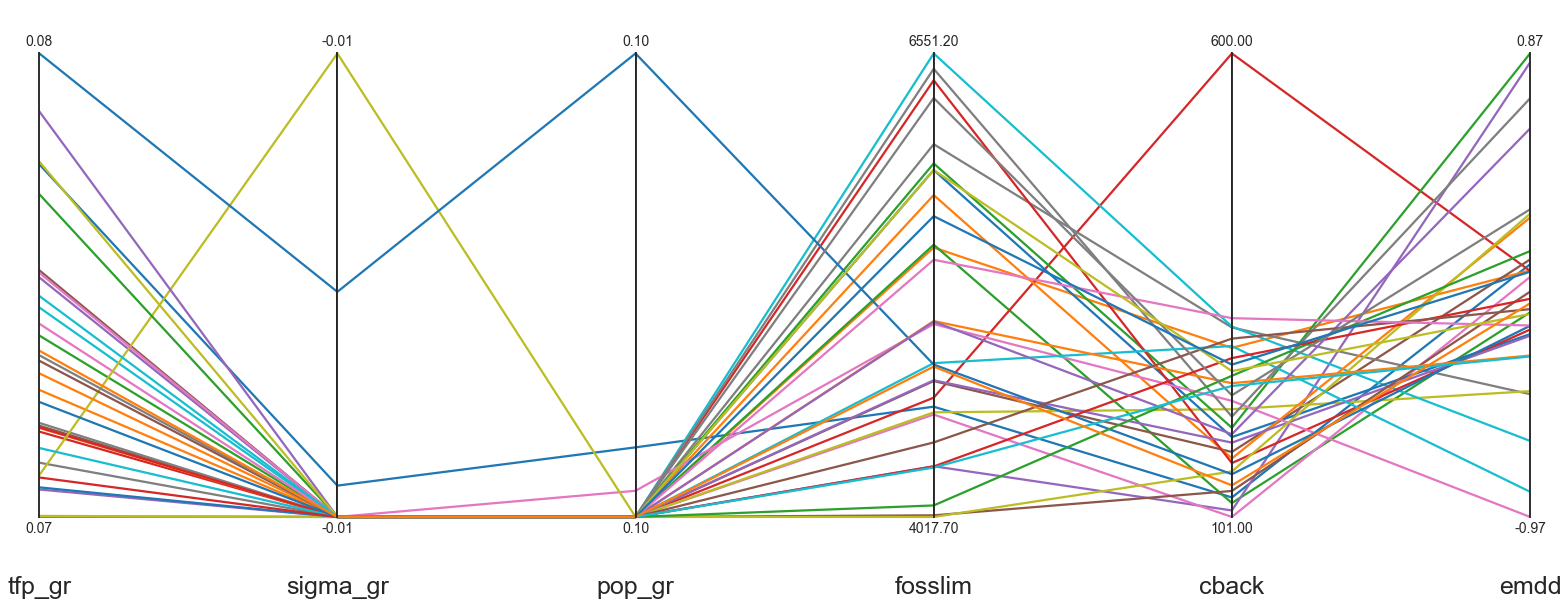

In [77]:
# V(D) switch OFF
paraxes = parcoords.ParallelAxes(limits, rot=0)
paraxes.plot(data)
paraxes.fig.set_size_inches(25,10)
change_fontsize(paraxes, fs=25)
plt.show()
paraxes.fig.savefig(os.path.join(fig_path, str(run) + 'DSearch_parcoords_VD_0' + '.png'))

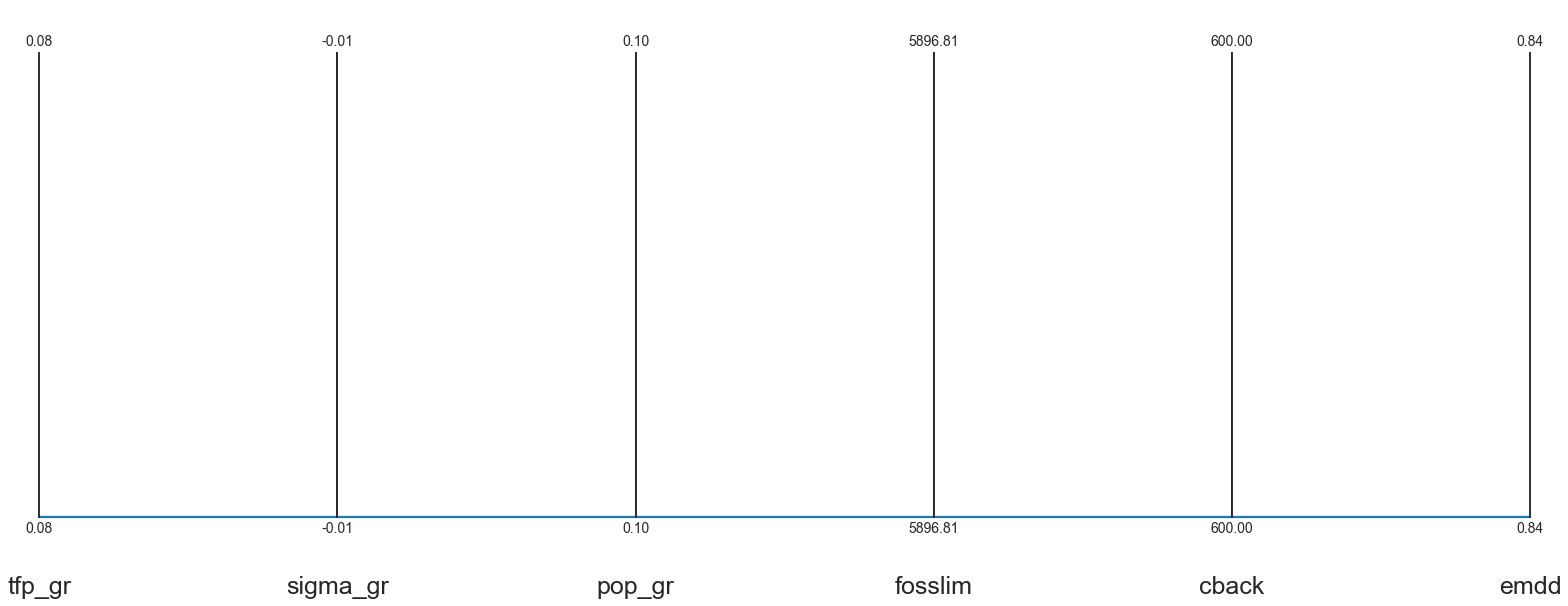

In [55]:
# V(D) switch ON
paraxes = parcoords.ParallelAxes(limits, rot=0)
paraxes.plot(data)
paraxes.fig.set_size_inches(25,10)
change_fontsize(paraxes, fs=25)
plt.show()
paraxes.fig.savefig(os.path.join(fig_path, str(run) + 'DSearch_parcoords_VD_1' + '.png'), bbox_inches='tight')

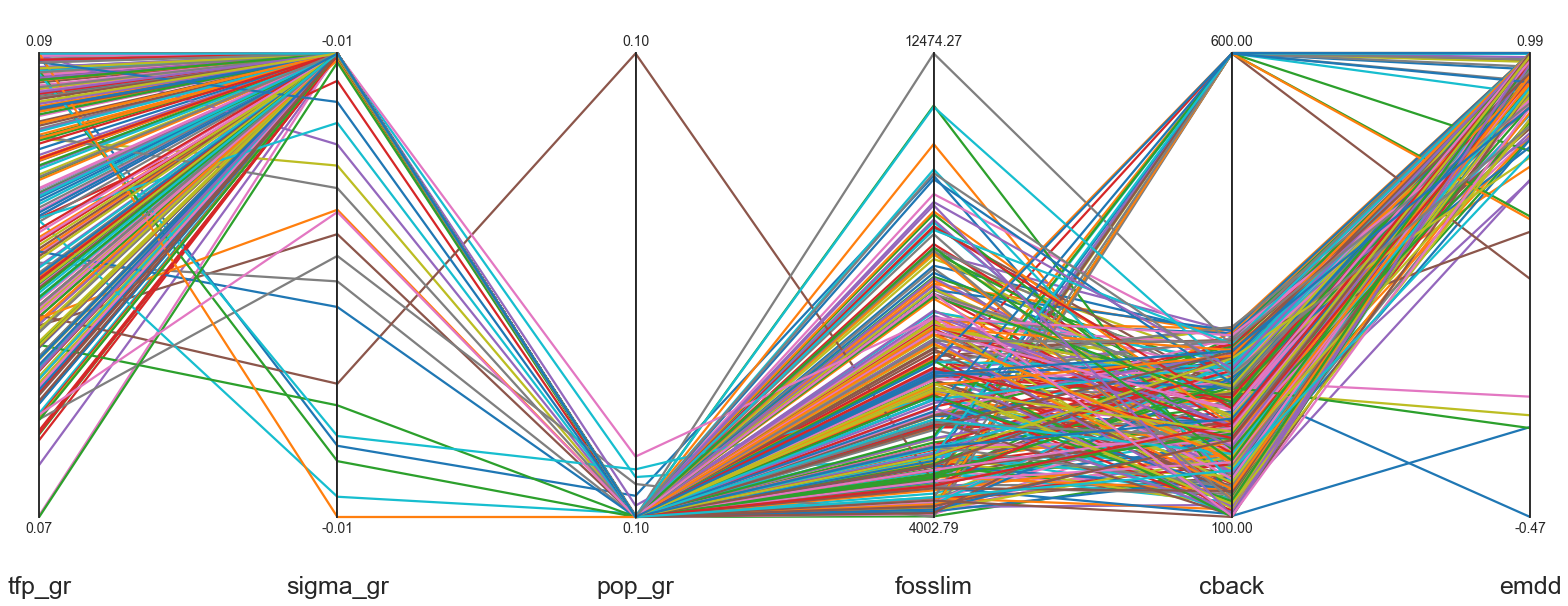

In [22]:
paraxes = parcoords.ParallelAxes(limits, rot=0)
paraxes.plot(data)
paraxes.fig.set_size_inches(25,10)
change_fontsize(paraxes, fs=25)
plt.show()
paraxes.fig.savefig(os.path.join(fig_path, str(run) + 'DSearch_parcoords' + '.png'), bbox_inches='tight')

In [ ]:
results